In [1]:
import os

os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/ra_joint_predictions')

In [2]:
from utils.config import Config

config = Config()

In [3]:
from dataset.joint_damage_type_dataset import joint_damage_type_dataset

wrists_narrowing = joint_damage_type_dataset(config, joint_extractor = None, repeat_test = False)
wrists_erosion = joint_damage_type_dataset(config, joint_extractor = None, repeat_test = False)

tf_wrists_j_data = wrists_narrowing.get_wrists_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = False)
tf_wrists_e_data = wrists_erosion.get_wrists_joint_damage_type_dataset_with_validation(config.train_location + '/training.csv', erosion_flag = True)

2020-05-14 15:24:12,547;WARNING - Missing permissions to create directory for caching!
[{'augment': <function random_brightness_and_contrast at 0x7f084be5e8c8>}, {'augment': <function random_crop at 0x7f084be5e9d8>, 'params': {'min_scale': 0.9}}, {'augment': <function random_gaussian_noise at 0x7f084be5ea60>, 'p': 0.2}, {'augment': <function random_rotation at 0x7f084be5e950>, 'params': {'max_rot': 10}}]
2020-05-14 15:24:15,707;WARNING - Missing permissions to create directory for caching!
[{'augment': <function random_brightness_and_contrast at 0x7f084be5e8c8>}, {'augment': <function random_crop at 0x7f084be5e9d8>, 'params': {'min_scale': 0.9}}, {'augment': <function random_gaussian_noise at 0x7f084be5ea60>, 'p': 0.2}, {'augment': <function random_rotation at 0x7f084be5e950>, 'params': {'max_rot': 10}}]


In [4]:
wrists_narrowing.alpha

array([0.74456522, 0.68478261, 0.82608696, 0.67391304, 0.85507246,
       0.86231884])

In [5]:
wrists_erosion.alpha

array([0.88949275, 0.75362319, 0.89492754, 0.63405797, 0.88043478,
       0.78623188])

In [10]:
import tensorflow.keras as keras

wrists_j_newshape_model = keras.models.load_model('../trained_models/narrowing/v7/wrists_narrowing_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_test.h5', compile = False)
wrists_j_newshape_right_model = keras.models.load_model('../trained_models/narrowing/v7/wrists_narrowing_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_left_group_test.h5', compile = False)
wrists_j_newshape_left_model = keras.models.load_model('../trained_models/narrowing/v7/wrists_narrowing_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_right_group_test.h5', compile = False)

wrists_e_newshape_model = keras.models.load_model('../trained_models/erosion/v7/wrists_erosion_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_test.h5', compile = False)
wrists_e_newshape_right_model = keras.models.load_model('../trained_models/erosion/v7/wrists_erosion_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_right_group_test.h5', compile = False)
wrists_e_newshape_left_model = keras.models.load_model('../trained_models/erosion/v7/wrists_erosion_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_left_group_test.h5', compile = False)

In [13]:
wrists_e_newshape_malhpa_model = keras.models.load_model('../trained_models/erosion/v7/wrists_erosion_joint_damage_type_model_complex_rewritten_gap_64bs_3normsteps_75epochs_adamW_3e4_1e6_new_shape_mean_alpha_test.h5', compile = False)

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

def print_metrics(models, ds, title, cutoff = 0.5):
    truths = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: []
    }
    
    preds = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: []
    }

    for x, y in ds[1]:  
        y_preds = np.zeros((x.shape[0], 6))
        
        for model in models:
            y_pred = model.predict(x) # [:, 0]
            
            for n in range(6):
                y_preds[:, n] += y_pred[n][:, 0]
        
        #for model in models[1:]:
            #y_pred += model.predict(x) # [:, 0]
        
        #y_pred = models[0].predict(x)   # [0][:, 0]
        
        #for model in models[1:]:
            #y_pred += model.predict(x) # [:, 0]
        
        # y_pred = np.array(y_pred)
        y_preds = y_preds / len(models)
        
        # print(y_pred)
        
        for n in range(6):
            truths[n].extend(y[n].numpy())
            preds[n].extend(y_preds[:, n])            
    
    fig = plt.figure(figsize = (24, 4))
    
    rows = {
        0: [],
        1: [],
        2: [],
        3: [],
        4: [],
        5: []
    }
    
    brier = np.zeros(6)
    auc = np.zeros(6)  
    
    for idx in range(6):
        t_vals = np.array(truths[idx])
        p_vals = np.array(preds[idx])
        
        brier[idx] = np.mean(np.square(t_vals - p_vals))
        auc[idx] = roc_auc_score(t_vals, p_vals)

        precs_0 = []
        recs_0 = []
        recs_1 = []

        cutoffs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

        for n in cutoffs:
            c_preds = np.zeros(p_vals.shape[0])
            c_preds[p_vals > n] = 1

            report = classification_report(t_vals, c_preds, output_dict = True)

            prec_0 = report['0']['precision']
            rec_0 = report['0']['recall']
            rec_1 = report['1']['recall']  

            precs_0.append(prec_0)
            recs_0.append(rec_0)
            recs_1.append(rec_1)

            rows[idx].append({
                'cutoff': n,
                'prec_0': prec_0,
                'rec_0': rec_0,
                'rec_1': rec_1

            })
            
        row_idx = 0
        col_idx = idx
        if idx > 2:
            row_idx = 1
            col_idx = idx - 3

        # plt.figure(figsize = (6, 4))
        plt.subplot(1, 6, idx+1)
        plt.plot(cutoffs, precs_0, label = 'Precision 0')
        plt.plot(cutoffs, recs_0, label = 'Recall_0')
        plt.plot(cutoffs, recs_1, label = 'Recall 1')
        plt.plot([cutoff, cutoff], [0, 1])
        plt.grid()
        plt.legend()
        plt.title(f'Output_{idx}')
    
    print('Brier', brier)
    print('AUC', auc)
    
    plt.suptitle(title)
    plt.show()
    
    x = list(map(lambda idx: pd.DataFrame(rows[idx], index = np.arange(len(rows[idx]))), range(6)))
    
    return x

Brier [0.29462335 0.35273437 0.20934018 0.36970699 0.17098117 0.16515075]
AUC [0.97232313 0.94502505 0.97916667 0.88916288 0.98267516 0.98022152]


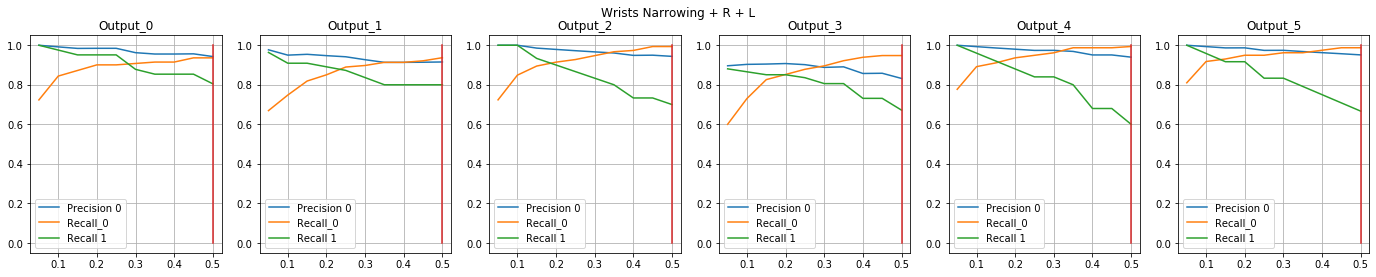

In [8]:
df = print_metrics([wrists_j_newshape_model, wrists_j_newshape_right_model, wrists_j_newshape_left_model], tf_wrists_j_data, 'Wrists Narrowing + R + L')

Brier [0.13308752 0.22028207 0.16233628 0.27144264 0.14945493 0.22052793]
AUC [0.84994726 0.78210624 0.85021097 0.79243499 0.92288761 0.85519922]


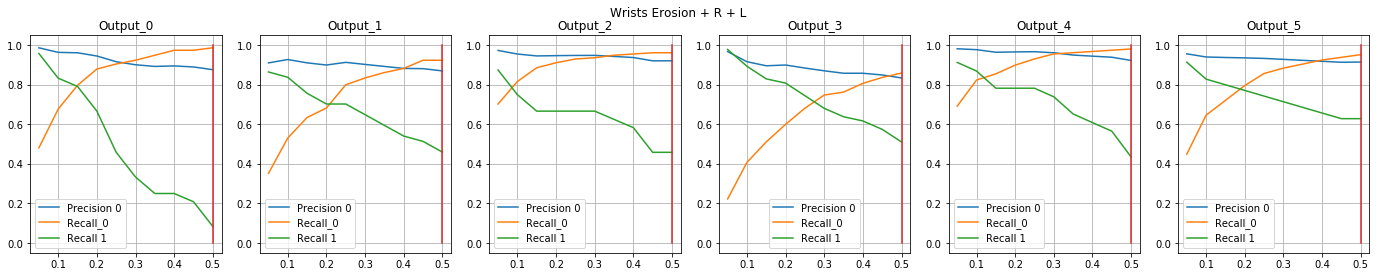

In [11]:
df = print_metrics([wrists_e_newshape_model, wrists_e_newshape_right_model, wrists_e_newshape_left_model], tf_wrists_e_data, 'Wrists Erosion + R + L')

Brier [0.15637657 0.23514336 0.17382953 0.31195667 0.15696897 0.23006212]
AUC [0.79905063 0.76999068 0.87341772 0.74483846 0.83921247 0.85072886]


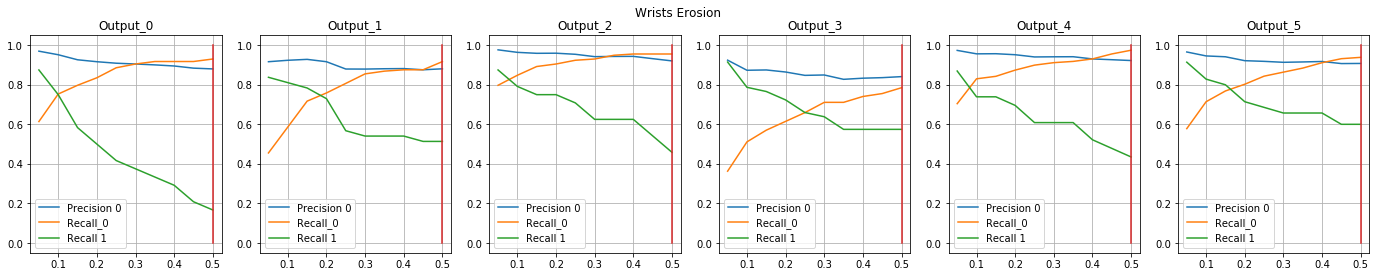

In [12]:
df = print_metrics([wrists_e_newshape_model], tf_wrists_e_data, 'Wrists Erosion')

Brier [0.14099414 0.23669128 0.16531334 0.29836087 0.14780066 0.2265212 ]
AUC [0.77241561 0.79366263 0.86392405 0.7750985  0.92398141 0.80758017]


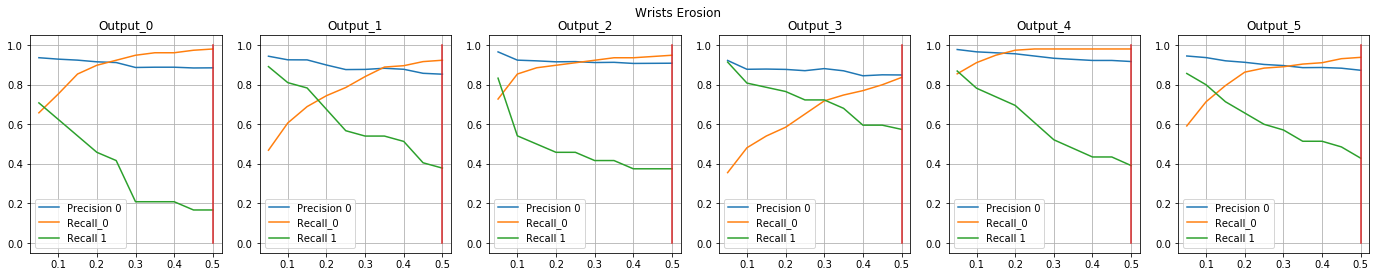

In [14]:
df = print_metrics([wrists_e_newshape_malhpa_model], tf_wrists_e_data, 'Wrists Erosion')